In [2]:
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import random as rnd
%matplotlib inline
import matplotlib.patches as mpatches
import seaborn as sns
import scipy

# InfGraph Class
* Contains, simulates and builds influence graphs and simulates belief changes over time.
* You have to keep its values throughout time if you want to print it or plot it.
* It also contains polarization measures due to bad software engineering, soon to be fixed.

Example:
```python
pol_sim = InfGraph(num_agts=100)
pol_sim.build_bel(bel_type="trypartite")
pol_sim.build_graph(graph_type="faintly-connected")

pol_sim.simulate(time=1, save_bel=True)
```

In [3]:
class InfGraph:
    
    def __init__(self, num_agts=0):
        self._num_agts = num_agts
        self._bel_time = []
        self._bel = np.zeros(num_agts)
        self._graph = np.zeros((num_agts,num_agts))
        
    def change_edge(self, i, j, inf):
        self._graph[i][j] = inf
        
    def change_bel(self, i, bel):
        self._bel[i] = bel
        
    def update_bel(self,  i, j, update_function="classic"):
        n = self._num_agts
        if(update_function == "classic"):
            return self._bel[i] + self._graph[j][i]*(self._bel[j]-self._bel[i])
        elif(update_function == "confirmation-bias"):
            f_confbias = 1 - abs(self._bel[i]-self._bel[j])
            return self._bel[i] + self._graph[j][i]*f_confbias*(self._bel[j]-self._bel[i])
        
    def update_node(self, i, update_function="classic"):
        n = self._num_agts
        ret = 0
        for j in range(n):
            ret += self.update_bel(i,j,update_function)
        ret /= n
        self._bel[i] = ret
        return ret
    
    def update_graph(self, update_function="classic"):
        for i in range(self._num_agts):
            self.update_node(i)
    
    def save(self):
        self._bel_time.append(np.copy(self._bel))
    
    def simulate(self, time=1, update_function="classic"):
        
        self.save()
        for i in range(time):
            self.update_graph()
            self.save()
        
    def build_graph(self, graph_type="clique", auto=True, zeros=0, inf=[]):
        #use auto = false if using parameters inf[]
        #use parameter zeros when graph_type = random to choose the prorportion of influence that
        #will be null
        n = self._num_agts
        if(graph_type == "clique"):
            for i in range(n):
                for j in range(n):
                    if(auto):
                        self.change_edge(i,j,0.5)
                    else:
                        self.change_edge(i,j,inf[0])
                    
        elif(graph_type == "disconnected"):
            for i in range(n):
                for j in range(n):
                    if(i+1 <= math.ceil(n/2) and j+1 <= math.ceil(n/2) or
                       i+1 > math.ceil(n/2) and j+1 > math.ceil(n/2)):
                        if(auto):
                            self.change_edge(i, j, 0.5)
                        else:
                            self.change_edge(i, j, inf[0])
                    else:
                        self.change_edge(i, j, 0)
                
        elif(graph_type == "faintly-connected"):
            for i in range(n):
                for j in range(n):
                    if(i+1 <= math.ceil(n/2) and j+1 <= math.ceil(n/2) or
                       i+1 > math.ceil(n/2) and j+1 > math.ceil(n/2)):
                        if(auto):
                            self.change_edge(i, j, 0.5)
                        else:
                            elsef.change_edge(i, j, inf[0])
                    else:
                        if(auto):
                            self.change_edge(i, j, 0.1)
                        else:
                            self.change_edge(i, j, inf[1])
                            
        elif(graph_type == "unrelenting-influencers"):
            # num_agts must be at least 2
            # inf1 = agt(0) and inf2 = agt(n-1)
            for i in range(n):
                for j in range(n):
                    if((i == 0 and j != n-1) or (i == n-1 and j!=0)):
                        if(auto):
                            self.change_edge(i, j, 0.6)
                        else:
                            self.change_edge(i, j, inf[1])
                    elif(i!=j and (j == 0 or j == n-1)):
                        self.change_edge(i, j, 0)
                    elif(0!=i and i!=n-1 and 0!=j and j!=n-1):
                        if(auto):
                            self.change_edge(i, j, 0.1)
                        else:
                            self.change_edge(i, j, inf[0])
                        
        elif(graph_type == "malleable-influencers"):
            # num_agts must be at least 2
            # inf1 = agt(0) and inf2 = agt(n-1)
            for i in range(n):
                for j in range(n):
                    if(i == 0 and j != n-1):
                        if(auto):
                            self.change_edge(i, j, 0.8)
                        else:
                            self.change_edge(i, j, inf[3])
                    elif(i!=n-1 and j!= 0):
                        if(auto):
                            self.change_edge(i, j, 0.5)
                        else:
                            self.change_edge(i, j, inf[2])
                    elif(i!=j and (j == 0 or j == n-1)):
                        if(auto):
                            self.change_edge(i, j, 0.1)
                        else:
                            self.change_edge(i, j, inf[0])
                    elif(0 != i and i != n-1 and 0 != j and j != n-1):
                        if(auto):
                            self.change_edge(i, j, 0.2)
                        else:
                            self.change_edge(i, j, inf[1])
                            
        elif(graph_type == "random"):
            for i in range(n):
                for j in range(n):
                    r = rnd.random()
                    if(r < zeros):
                        self.change_edge(i,j,0)
                    else:
                        self.change_edge(i,j,rnd.random())
                        
    def build_bel(self, bel_type="uniform", auto=True, inf=[]):
        #if passing inf as parameters pass auto=False
        #pass inf in increasing order
        n = self._num_agts
        if(bel_type == "uniform"):
            for i in range(self._num_agts):
                self.change_bel(i, i/(n-1))
                    
        elif(bel_type == "mildly-polarized"):
            for i in range(n):
                if(i < math.ceil(n/2)):
                    self.change_bel(i,max(0.25-0.01*(math.ceil(n/2)-i-1), 0))
                else:
                    self.change_bel(i,min(0.75-0.01*(math.ceil(n/2)-i),1))
            
        elif(bel_type == "extremely-polarized"):
            for i in range(n):
                #I put < instead of <= because it made more sense in the case n is odd
                if(i < math.ceil(n/2)):
                    if(auto):
                        self.change_bel(i,0)
                    else:
                        self.change_bel(i,inf[0])
                else:
                    if(auto):
                        self.change_bel(i,1)
                    else:
                        self.change_bel(i,inf[1])
                    
        elif(bel_type == "trypartite"):
            for i in range(n):
                if(i < math.floor(n/3)):
                    if(auto):
                        self.change_bel(i,0)
                    else:
                        self.change_bel(i,inf[0])
                elif (i < math.ceil(2*(n/3))):
                    if(auto):
                        self.change_bel(i,0.5)
                    else:
                        self.change_bel(i,inf[1])
                else:
                    if(auto):
                        self.change_bel(i,1)
                    else:
                        self.change_bel(i,inf[2])
        elif(bel_type == "random"):
            for i in range(n):
                self.change_bel(i,rnd.random())

# InfPrint class
* Receives a **InfGraph** as a parameter
* Prints (not plots) some informations of InfGraph
* Remember to save the informations on the **InfGraph**

Example:

```python
myinfgraph = InfGraph(num_agts = 5)

myprint = InfPrint(myinfgraph)

myprint.print_bel()
```

In [4]:
class InfPrint:
    
    def __init__(self, InfGraph):
        self.inf = InfGraph
    def print_graph(self, adj_list=False):
        if(adj_list == False):
            for i in range(self.inf._num_agts):
                for j in range(self.inf._num_agts):
                    print('%.2f' %self.inf._graph[i][j], end = " ")
                print()
            print()
        else:
            for i in range(self._num_agts):
                print(i, end=": ")
                for j in range(self._num_agts):
                    if(self.inf._graph[i][j] != 0):
                        print("(",j,",",self.inf._graph[i][j],")",end=", ")
                print()

    def print_bel(self):
        print(self.inf._bel)
        print()

    def print_time(self):
        for i in range(len(self.inf._bel_time)):
            print(self.inf._bel_time[i])

# InfPlot Class
* Plots some informations of **InfGraph** or of Polarization
* Remember to save the informations on the **InfGraph**

Example:
```python
pol_sim = InfGraph(num_agts=100)

pol_plot = InfPlot()

pol_plot.plot_bel(pol_sim)
```

In [5]:
class InfPlot:
    
    def plot_bel(self, InfGraph):
        fig = plt.gcf()
        fig.set_size_inches(15, 10)

        for i in range(InfGraph._num_agts):
            aux = []
            for j in range(len(InfGraph._bel_time)):
                aux.append(InfGraph._bel_time[j][i])
            plt.plot(aux, '--')

        plt.xlabel("Time")
        plt.ylabel("Belief")
        plt.show()
    
    def plot_pol(self, pol_time):
        fig = plt.gcf()
        fig.set_size_inches(6, 4)
        plt.plot(pol_time, 'r--')
        plt.xlabel("Time")
        plt.ylabel("Polarization")

# Continuous Polarization Auxiliary Functions
* To be honest, I do not now exactly how these work, but I took it from [here](http://www.jtrive.com/kernel-density-estimation-in-python.html).
* The second article from Esteban and Ray did not provide as much information on this topic, but it states that the Gaussian should be a good kernel function and that the bandwidth function $f$ should satisfact $f \in \mathcal{O}\left(\frac{1}{\sqrt{n}}\right)$, being $n$ the number of points on the distribution (in our case, the number of agents)

In [6]:
pol_sim = InfGraph(num_agts=20)
pol_sim.build_bel(bel_type="trypartite")
pol_sim.build_graph(graph_type="faintly-connected")

pol_sim.simulate(time=1)

pol_plot = InfPlot()

[0.09       0.09225    0.09455625 0.09692016 0.09934316 0.10182674
 0.45437241 0.45323172 0.45206251 0.45086407 0.56192714 0.56347531
 0.5650622  0.56668875 0.91835597 0.91631487 0.91422274 0.91207831
 0.90988027 0.90762727]


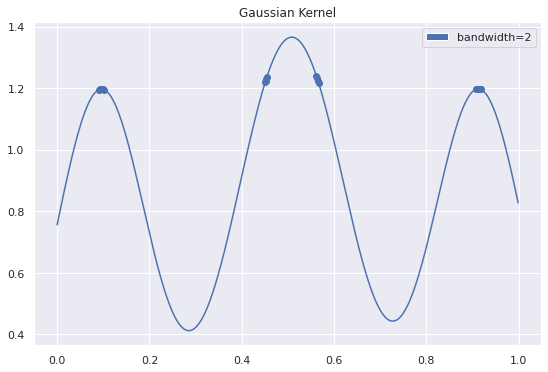

In [7]:
# ===================================================
# kde_pdf and kde_cdf are used for compiling kernel |
# density and distribution estimates.               |
# ===================================================


def kde_pdf(data, kernel_func, bandwidth):
    """Generate kernel density estimator over data."""
    kernels = dict()
    n = len(data)
    for d in data:
        kernels[d] = kernel_func(d, bandwidth)
    def evaluate(x):
        """Evaluate `x` using kernels above."""
        pdfs = list()
        for d in data: pdfs.append(kernels[d](x))
        return(sum(pdfs)/n)
    return(evaluate)

# ============================================
# Gaussian Kernel PDF                        |
# ============================================

def gaussian_pdf(x_i, bandwidth):
    """Return Gaussian kernel density estimator."""
    x_bar  = x_i
    def evaluate(x):
        """Evaluate x."""
        pdf = (np.sqrt(2*np.pi*bandwidth**2)**-1) * np.exp(-((x - x_bar)**2)/(2*bandwidth**2))
        return(pdf)
    return(evaluate)

# ===============================================
# Logic for producing kernel density estimate   |
# vizualizations.                               |
# ===============================================

sns.set(color_codes=True)
plt.rcParams["figure.figsize"] = (15,10)

vals  = pol_sim._bel
print(vals)
avals = np.array(vals)
xvals = np.arange(0, 1,.001)

fig = plt.figure()

# bandwidth should be = (1/sqrt(number of agents)):
ax2 = fig.add_subplot(2, 2, 1)
dist_2 = kde_pdf(data=vals, kernel_func=gaussian_pdf, bandwidth=.1)
y2 = [dist_2(i) for i in xvals]
ys2 = [dist_2(i) for i in vals]
ax2.scatter(vals, ys2)
ax2.plot(xvals, y2)

# set title
t2=ax2.set_title(r"Gaussian Kernel")


# display legend in each subplot
leg2 = mpatches.Patch(color=None, label='bandwidth=2')

ax2.legend(handles=[leg2])

plt.tight_layout()
plt.show()

# Pol Class
* Measures polarization over time according to various metrics using a vector of beliefs over time.
* Discrete:
    * k = number of buckets (k = 10)
    * K = multiplying constant (K = 10)
    * a = $\alpha$ (a = 1.6)
* Continuous:
    * a = $\alpha$ (a = 0.75) ($\alpha \in [0.25, 1]$)

Example:
```python
pol_sim = InfGraph(num_agts=3)

pol = Pol(pol_sim._bel_time)

print(pol.calc_discrete_pol_time())
```

In [16]:
class Pol:
        def __init__(self, bel):
            self._bel = bel
            self._num_agts = len(bel[0])
            self._time = len(bel)
        def discrete_pol(self, time, pol_type="original", k=10, K=10, a=1.6):
            pol = 0
            pi = np.zeros(k)
            interval_size = 1/k
            if(pol_type == "original"):
                for bel in self._bel[time]:
                    #assuming 1 belongs to the last bin
                    pos = min(math.floor(bel/interval_size), k-1)
                    pi[pos] += 1/self._num_agts

                for i in range(k):
                    for j in range(k):
                       pol += (pi[i]**(1+a))*pi[j]*abs((i-j)*interval_size)

            elif(pol_type == "average"):
                yi = np.zeros(k)

                for bel in self._bel[time]:
                    #assuming 1 belongs to the last bin
                    pos = min(math.floor(bel/interval_size), k-1)
                    pi[pos] += 1
                    yi[pos] += bel

                for i in range(k):
                    if(pi[i] > 0):
                        yi[i] /= pi[i]
                        pi[i] /= self._num_agts

                for i in range(k):
                    for j in range(k):
                       pol += (pi[i]**(1+a))*pi[j]*abs(yi[i]-yi[j])

            return K*pol
    
        def discrete_pol_time(self, pol_type="original", k=10, K=10, a=1.6):
            pol_time = []
            for i in range(self._time):
                pol_time.append(self.discrete_pol(i,pol_type,k,K,a))
            
            return pol_time
        
        def continuous_pol(self, time, a=0.75):
            pol = 0                    
            
            sigma = np.var(self._bel[time])
            IQ = scipy.stats.iqr(self._bel[time])
            n = self._num_agts
            optimal_bandwidth = (n**(-0.5)) * IQ * (3.76+14.7*sigma)/((1 + 1.09*1e-4 * sigma)**(7268+15323*a)) 
            
            vals  = self._bel[time]
                
            dist = kde_pdf(data=vals, kernel_func=gaussian_pdf, 
                           bandwidth=optimal_bandwidth)
            
            deltas = np.arange(0,1,0.01)
            for i in deltas:
                for j in deltas:
                    pol += (dist(i)**(1+a)) * dist(j) * abs(j-i)
            if time == 45:        
                xvals = np.arange(0, 1,.001)

                fig = plt.figure()
                ax2 = fig.add_subplot(2, 2, 1)
                
                y2 = [dist(i) for i in xvals]
                ys2 = [dist(i) for i in vals]
                ax2.scatter(vals, ys2)
                ax2.plot(xvals, y2)

                # set title
                t2=ax2.set_title(r"Gaussian Kernel")


                # display legend in each subplot
                leg2 = mpatches.Patch(color=None, label='bandwidth=2')

                ax2.legend(handles=[leg2])

                plt.show()
            
            return pol
        
        def continuous_pol_time(self, a=0.75):
            pol_time = []
            for i in range(self._time):
                pol_time.append(self.continuous_pol(i,a))
            
            return pol_time

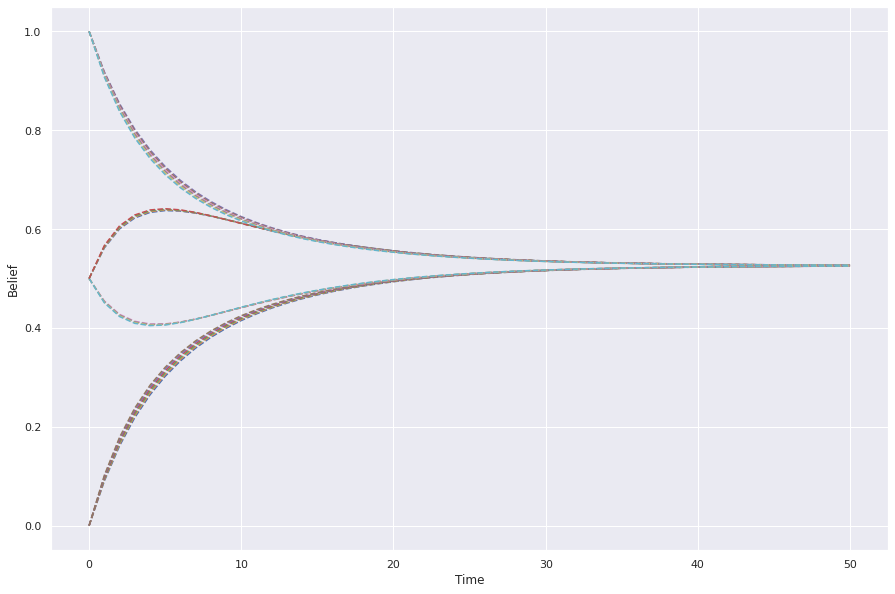

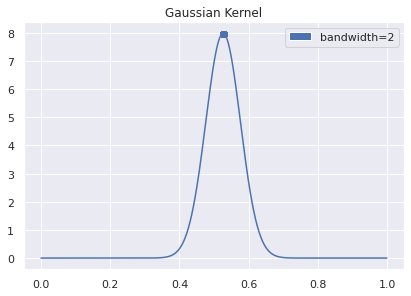

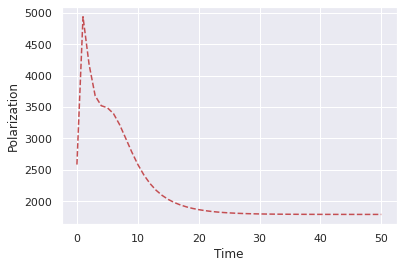

In [17]:
pol_sim = InfGraph(num_agts=20)
pol_sim.build_bel(bel_type="trypartite")
pol_sim.build_graph(graph_type="faintly-connected")

pol_sim.simulate(time=50)

pol_plot = InfPlot()
pol_plot.plot_bel(pol_sim)

pol = Pol(pol_sim._bel_time)

pol_time = pol.continuous_pol_time()

pol_plot.plot_pol(pol_time)